# Case Study #1 : Investigation Evidence
Do the image enhancement to get the good and usable images. Explain why and how?

## Case 1 - Image 1

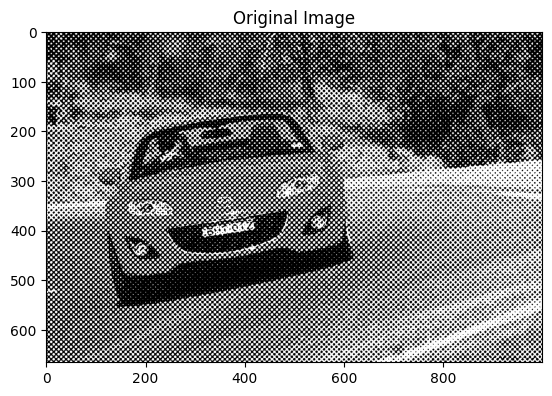

In [24]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load image in grayscale
img = cv2.imread('case1_1.png', 0)
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.show()

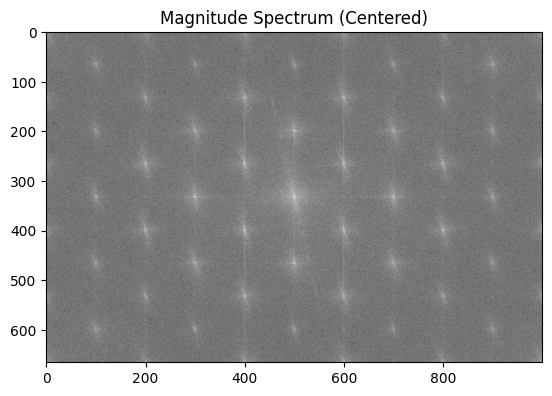

In [25]:
# Get image size
M, N = img.shape

# Compute DFT using FFT
f = np.fft.fft2(img)

# Shift zero frequency to center
fshift = np.fft.fftshift(f)

# Calculate magnitude spectrum (for visualization)
magnitude_spectrum = 20 * np.log(np.abs(fshift) + 1)

plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('Magnitude Spectrum (Centered)')
plt.show()

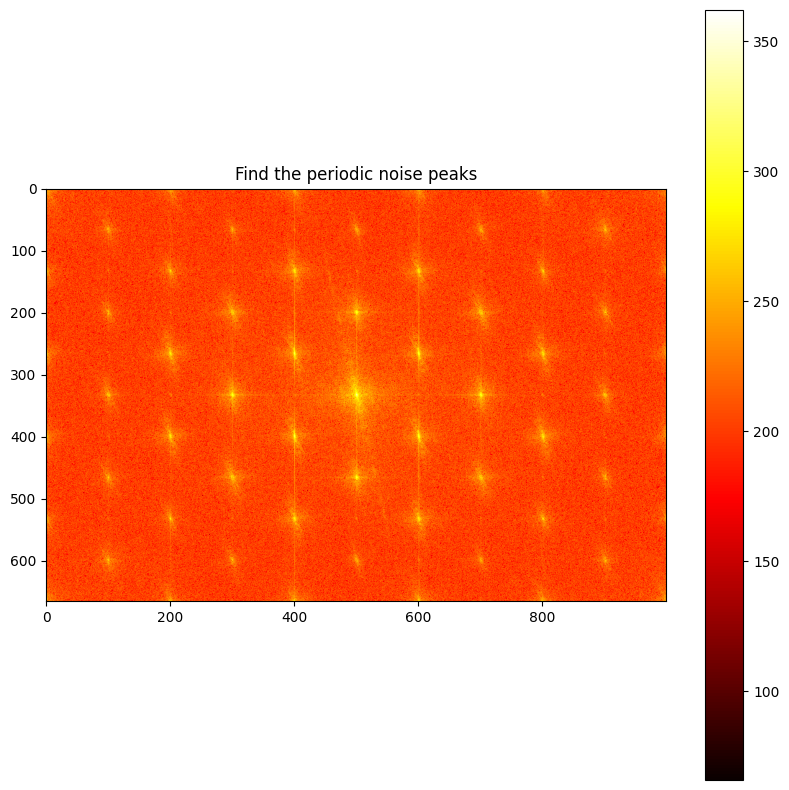

In [26]:
# Display with better contrast to find peaks
plt.figure(figsize=(10, 10))
plt.imshow(magnitude_spectrum, cmap='hot')
plt.colorbar()
plt.title('Find the periodic noise peaks')
plt.show()

In [8]:
def create_gaussian_notch_filter(shape, sigma, notch_centers):
    """
    Create Gaussian notch reject filter (smoother than hard zeroing)
    Based on: https://stackoverflow.com/a/29246091
    
    shape: (M, N) size of filter
    sigma: standard deviation of Gaussian (controls notch width)
    notch_centers: list of (u, v) coordinates of noise peaks
    """
    M, N = shape
    
    # Create coordinate grids
    v, u = np.meshgrid(np.arange(N), np.arange(M))
    
    # Start with all-pass filter
    H = np.ones((M, N))
    
    # Create Gaussian notch for each peak
    for (u_k, v_k) in notch_centers:
        # Distance from peak center
        D_k_sq = (u - u_k)**2 + (v - v_k)**2
        
        # Gaussian notch: 1 - exp(-D^2 / (2*sigma^2))
        # At peak center: H = 1 - exp(0) = 0 (blocks)
        # Far from peak: H = 1 - exp(-large) ≈ 1 (passes)
        notch_k = 1 - np.exp(-D_k_sq / (2 * sigma**2))
        
        H = H * notch_k
    
    return H

In [9]:
# --- Find noise peaks using skimage peak_local_max ---
from skimage.feature import peak_local_max

# Find local maxima in the magnitude spectrum
# min_distance controls how far apart peaks must be
coordinates = peak_local_max(magnitude_spectrum, min_distance=6, exclude_border=0)

print(f"Found {len(coordinates)} peaks:")
print("Coordinates (row, col):")
for i, coord in enumerate(coordinates):
    print(f"  Peak {i}: ({coord[0]}, {coord[1]})")

Found 3275 peaks:
Coordinates (row, col):
  Peak 0: (333, 500)
  Peak 1: (266, 400)
  Peak 2: (400, 600)
  Peak 3: (266, 600)
  Peak 4: (400, 400)
  Peak 5: (133, 600)
  Peak 6: (533, 400)
  Peak 7: (133, 400)
  Peak 8: (533, 600)
  Peak 9: (266, 200)
  Peak 10: (400, 800)
  Peak 11: (0, 400)
  Peak 12: (0, 600)
  Peak 13: (199, 500)
  Peak 14: (467, 500)
  Peak 15: (266, 800)
  Peak 16: (400, 200)
  Peak 17: (332, 300)
  Peak 18: (334, 700)
  Peak 19: (266, 0)
  Peak 20: (400, 0)
  Peak 21: (133, 200)
  Peak 22: (533, 800)
  Peak 23: (133, 800)
  Peak 24: (533, 200)
  Peak 25: (0, 200)
  Peak 26: (0, 800)
  Peak 27: (133, 0)
  Peak 28: (533, 0)
  Peak 29: (1, 0)
  Peak 30: (665, 0)
  Peak 31: (199, 100)
  Peak 32: (467, 900)
  Peak 33: (665, 400)
  Peak 34: (665, 600)
  Peak 35: (199, 900)
  Peak 36: (467, 100)
  Peak 37: (200, 701)
  Peak 38: (466, 299)
  Peak 39: (67, 700)
  Peak 40: (599, 300)
  Peak 41: (66, 300)
  Peak 42: (600, 700)
  Peak 43: (200, 301)
  Peak 44: (466, 699)
  

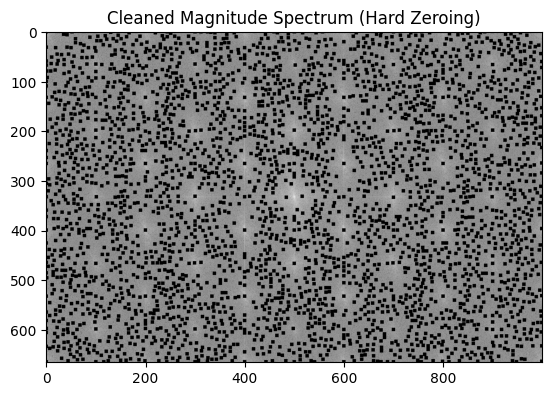

In [11]:
# --- Method 1: Hard Zeroing (Original Approach) ---
L = 3
dx, dy = img.shape[0], img.shape[1]

cleaned_spectrum = magnitude_spectrum.copy()
fshift_cleaned = fshift.copy()

center_x, center_y = dx // 2, dy // 2

for coord in coordinates:
    i, j = coord[0], coord[1]
    
    if i == center_x and j == center_y:
        continue
    
    for k1 in range(-L, L+1):
        for k2 in range(-L, L+1):
            new_i = i + k1
            new_j = j + k2
            if 0 <= new_i < dx and 0 <= new_j < dy:
                cleaned_spectrum[new_i, new_j] = 0
                fshift_cleaned[new_i, new_j] = 0

plt.imshow(cleaned_spectrum, cmap='gray')
plt.title('Cleaned Magnitude Spectrum (Hard Zeroing)')
plt.show()

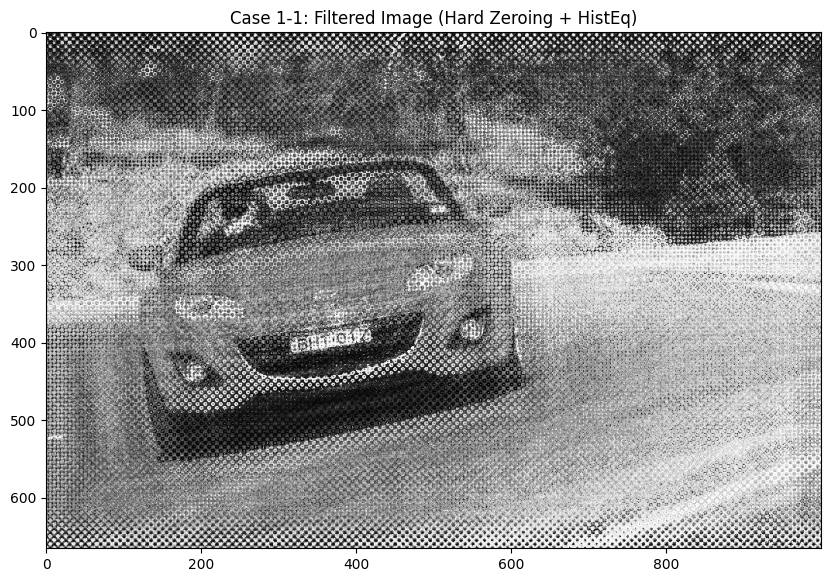

In [48]:
# --- Inverse FFT to get filtered image (Case 1 - Image 1) ---
# Apply IFFT to the hard-zeroed spectrum
img1_filtered = np.fft.ifftshift(fshift_cleaned)
img1_filtered = np.fft.ifft2(img1_filtered)
img1_filtered = np.real(img1_filtered)

# Normalize to 0-1 range
norm_img = lambda img: (img - np.min(img)) / (np.max(img) - np.min(img))
img1_filtered = norm_img(img1_filtered)

# Convert to 0-255 and apply histogram equalization
img1_filtered = cv2.equalizeHist((img1_filtered * 255).astype(np.uint8))

plt.figure(figsize=(10, 8))
plt.imshow(img1_filtered, cmap='gray')
plt.title('Case 1-1: Filtered Image (Hard Zeroing + HistEq)')
plt.show()

## Case 1 - Image 2

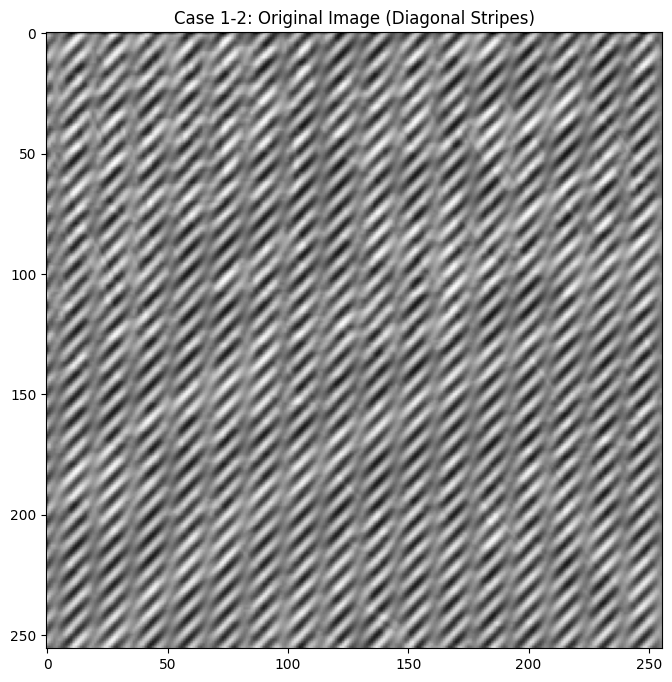

In [43]:
# Load case1_2.png
img2 = cv2.imread('case1_2.png', 0)

plt.figure(figsize=(8, 8))
plt.imshow(img2, cmap='gray')
plt.title('Case 1-2: Original Image (Diagonal Stripes)')
plt.show()

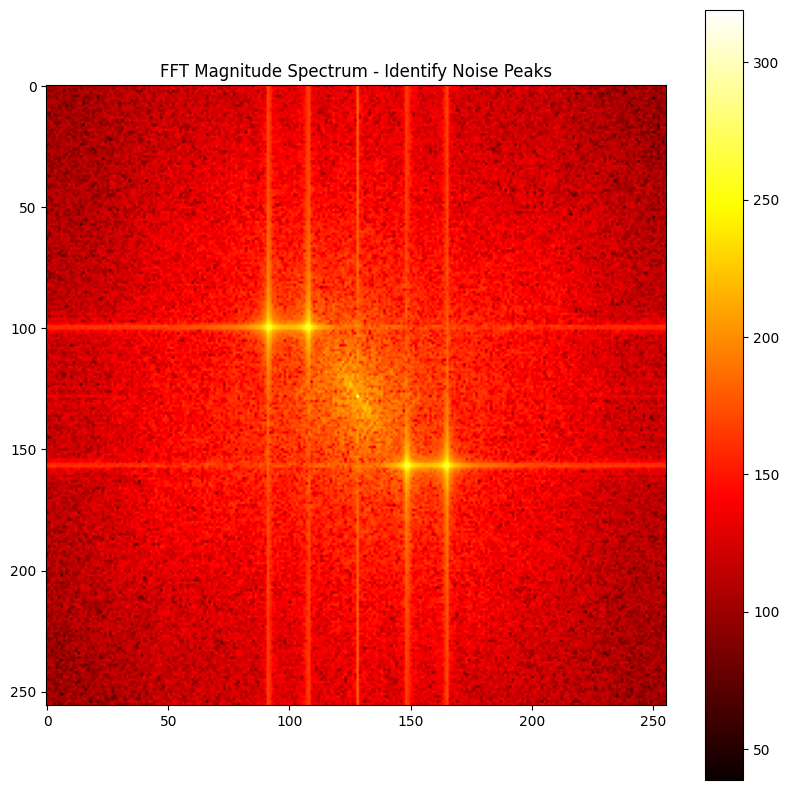

In [44]:
# Compute FFT
M2, N2 = img2.shape
f2 = np.fft.fft2(img2)
fshift2 = np.fft.fftshift(f2)
magnitude_spectrum2 = 20 * np.log(np.abs(fshift2) + 1)

# Visualize spectrum with hot colormap to identify noise peaks
plt.figure(figsize=(10, 10))
plt.imshow(magnitude_spectrum2, cmap='hot')
plt.colorbar()
plt.title('FFT Magnitude Spectrum - Identify Noise Peaks')
plt.show()

In [45]:
# --- Find noise peaks for Image 2 ---
from skimage.feature import peak_local_max

# Find local maxima in the magnitude spectrum
coordinates2 = peak_local_max(magnitude_spectrum2, min_distance=6, exclude_border=0)

print(f"Found {len(coordinates2)} peaks:")
print("Coordinates (row, col):")
for i, coord in enumerate(coordinates2):
    print(f"  Peak {i}: ({coord[0]}, {coord[1]})")

Found 275 peaks:
Coordinates (row, col):
  Peak 0: (128, 128)
  Peak 1: (99, 91)
  Peak 2: (157, 165)
  Peak 3: (99, 108)
  Peak 4: (157, 148)
  Peak 5: (156, 116)
  Peak 6: (100, 140)
  Peak 7: (138, 91)
  Peak 8: (118, 165)
  Peak 9: (78, 128)
  Peak 10: (178, 128)
  Peak 11: (58, 91)
  Peak 12: (198, 165)
  Peak 13: (66, 128)
  Peak 14: (190, 128)
  Peak 15: (105, 165)
  Peak 16: (151, 91)
  Peak 17: (98, 165)
  Peak 18: (158, 91)
  Peak 19: (48, 128)
  Peak 20: (208, 128)
  Peak 21: (40, 128)
  Peak 22: (216, 128)
  Peak 23: (20, 128)
  Peak 24: (236, 128)
  Peak 25: (8, 128)
  Peak 26: (248, 128)
  Peak 27: (0, 128)
  Peak 28: (77, 165)
  Peak 29: (179, 91)
  Peak 30: (99, 60)
  Peak 31: (157, 196)
  Peak 32: (71, 148)
  Peak 33: (185, 108)
  Peak 34: (40, 91)
  Peak 35: (216, 165)
  Peak 36: (156, 66)
  Peak 37: (100, 190)
  Peak 38: (121, 173)
  Peak 39: (135, 83)
  Peak 40: (42, 108)
  Peak 41: (214, 148)
  Peak 42: (225, 165)
  Peak 43: (31, 91)
  Peak 44: (99, 48)
  Peak 45: 

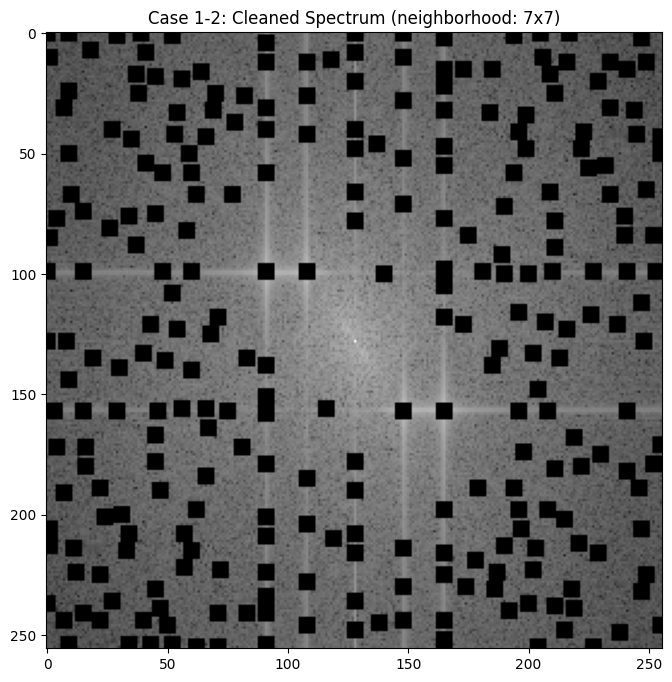

In [46]:
# --- Hard Zeroing Method for Image 2 (same as Image 1) ---
L2 = 3
dx2, dy2 = img2.shape[0], img2.shape[1]

cleaned_spectrum2 = magnitude_spectrum2.copy()
fshift_cleaned2 = fshift2.copy()

center_x2, center_y2 = dx2 // 2, dy2 // 2

# Zero out each peak (except DC center)
for coord in coordinates2:
    i, j = coord[0], coord[1]
    
    # Skip the DC component (center)
    if i == center_x2 and j == center_y2:
        continue
    
    # Zero out a (2L2+1) x (2L2+1) neighborhood around the peak
    for k1 in range(-L2, L2+1):
        for k2 in range(-L2, L2+1):
            new_i = i + k1
            new_j = j + k2
            if 0 <= new_i < dx2 and 0 <= new_j < dy2:
                cleaned_spectrum2[new_i, new_j] = 0
                fshift_cleaned2[new_i, new_j] = 0

# Visualize cleaned spectrum
plt.figure(figsize=(8, 8))
plt.imshow(cleaned_spectrum2, cmap='gray')
plt.title(f'Case 1-2: Cleaned Spectrum (neighborhood: {2*L2+1}x{2*L2+1})')
plt.show()

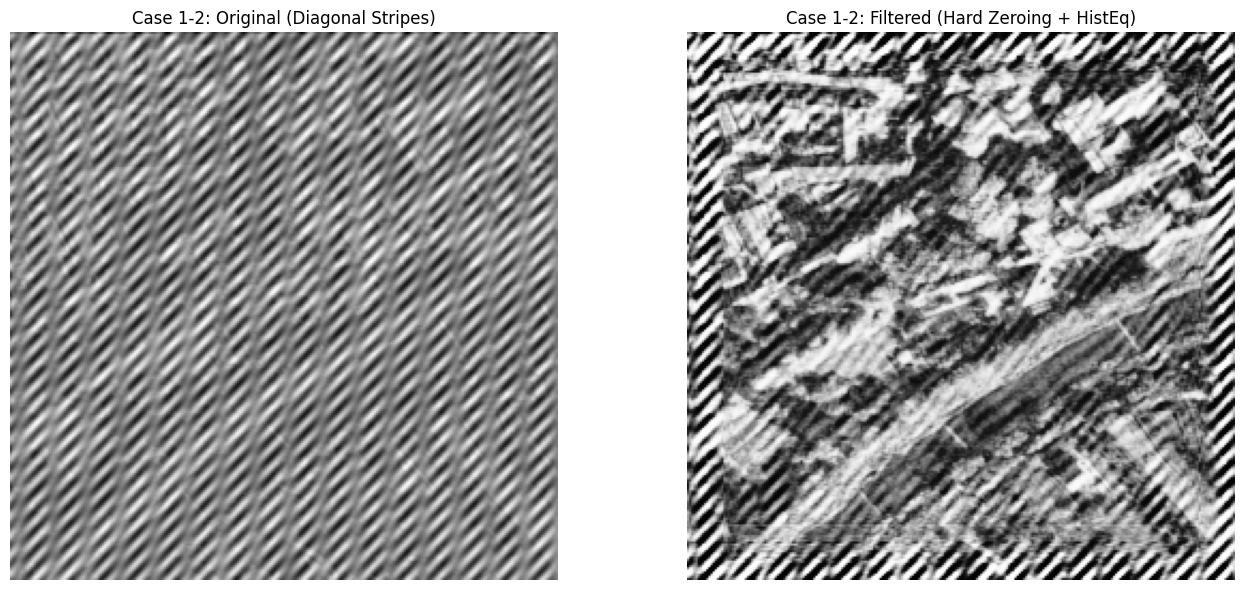

In [47]:
# --- Inverse FFT for Image 2 (same pipeline as Image 1) ---
# Apply IFFT to the hard-zeroed spectrum
img2_filtered = np.fft.ifftshift(fshift_cleaned2)
img2_filtered = np.fft.ifft2(img2_filtered)
img2_filtered = np.real(img2_filtered)

# Normalize to 0-1 range
norm_img = lambda img: (img - np.min(img)) / (np.max(img) - np.min(img))
img2_filtered = norm_img(img2_filtered)

# Convert to 0-255 and apply histogram equalization
img2_filtered = cv2.equalizeHist((img2_filtered * 255).astype(np.uint8))

# Display comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].imshow(img2, cmap='gray')
axes[0].set_title('Case 1-2: Original (Diagonal Stripes)')
axes[0].axis('off')

axes[1].imshow(img2_filtered, cmap='gray')
axes[1].set_title('Case 1-2: Filtered (Hard Zeroing + HistEq)')
axes[1].axis('off')

plt.tight_layout()
plt.show()